In [146]:
# # magic
# %load_ext autoreload
# %autoreload 2 
# #any changes to the function files will be updated on every run
# #%pdb 1 
# #where code fails, stops at that breakpoint and allows to examine potential error
# %matplotlib inline

In [147]:
import numpy as np
from functools import partial
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm
import sklearn.mixture
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as ss
from jax.scipy.stats import multivariate_normal, norm

from scipy.stats import multivariate_normal as ss_multivariate_normal
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import scipy
from scipy.spatial import distance
import warnings


In [148]:
key = random.PRNGKey(68)
key1 = random.PRNGKey(6898)
key2 = random.PRNGKey(681998)
subkeys = random.split(key, 5000)
subkeys1 = random.split(key1, 5000)

In [149]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

In [150]:
# from f_mean_adjust_ss_wasserstein_toad_without_tau import (toad, compute_summaries, compute_summaries_stacked, mean_adjustment_summary_statistics, radial_flow, nf_transform)

In [151]:
def toad(alpha,
         gamma,
         p0,
         n_toads=66,
         n_days=63,
         batch_size=1,
         random_state=None):
    """Sample the movement of Fowler's toad species.
    Models foraging steps using a levy_stable distribution where individuals
    either return to a previous site or establish a new one.
    References
    ----------
    Marchand, P., Boenke, M., and Green, D. M. (2017).
    A stochastic movement model reproduces patterns of site fidelity and long-
    distance dispersal in a population of fowlers toads (anaxyrus fowleri).
    Ecological Modelling,360:63–69.
    Parameters
    ----------
    alpha : float or array_like with batch_size entries
        step length distribution stability parameter
    gamma : float or array_like with batch_size entries
        step lentgh distribution scale parameter
    p0 : float or array_like with batch_size entries
        probability of returning to a previous refuge site
    n_toads : int, optional
        number of toads
    n_days : int, optional
        number of days
    batch_size : int, optional
    random_state : RandomState, optional
    Returns
    -------
    np.ndarray in shape (n_days x n_toads x batch_size)
    """
    X = np.zeros((n_days, n_toads, batch_size))
    random_state = random_state or np.random
    step_gen = ss.levy_stable
    step_gen.random_state = random_state

    for i in range(1, n_days):
        ret = random_state.uniform(0, 1, (n_toads, batch_size)) < np.squeeze(p0)
        non_ret = np.invert(ret)

        delta_x = step_gen.rvs(alpha, beta=0, scale=gamma, size=(n_toads, batch_size))
        X[i, non_ret] = X[i-1, non_ret] + delta_x[non_ret]

        ind_refuge = random_state.choice(i, size=(n_toads, batch_size))
        X[i, ret] = X[ind_refuge[ret], ret]

    return X


def compute_summaries(X, lag, p=np.linspace(0, 1, 3), thd=10):
    """Compute summaries for toad model.
    For displacements over lag...
        Log of the differences in the p quantiles
        The number of absolute displacements less than thd
        Median of the absolute displacements greater than thd
    Parameters
    ----------
    X : np.array of shape (ndays x ntoads x batch_size)
        observed matrix of toad displacements
    lag : list of ints, optional
        the number of days behind to compute displacement with
    p : np.array, optional
        quantiles used in summary statistic calculation (default 0, 0.1, ... 1)
    thd : float
        toads are considered returned when absolute displacement does not exceed thd (default 10m)
    Returns
    -------
    np.ndarray in shape (batch_size x len(p) + 1)
    """
    disp = obs_mat_to_deltax(X, lag)  # num disp at lag x batch size
    abs_disp = np.abs(disp)
    # returned toads
    ret = abs_disp < thd
    num_ret = np.sum(ret, axis=0)
    # non-returned toads
    abs_disp[ret] = np.nan  # ignore returned toads
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'All-NaN slice encountered')
        # abs_noret_median = np.nanmedian(abs_disp, axis=0)
        abs_noret_quantiles = np.nanquantile(abs_disp, p, axis=0)
    diff = np.diff(abs_noret_quantiles, axis=0)
    logdiff = np.log(np.maximum(diff, np.exp(-20)))  # substitute zeros with a small positive
    # combine
    # ssx = np.vstack((num_ret, abs_noret_median, logdiff))
    ssx = np.vstack((np.log(num_ret), logdiff))
    ssx = np.nan_to_num(ssx, nan=np.inf)  # nans are when all toads returned
    return np.transpose(ssx)


def obs_mat_to_deltax(X, lag):
    """Convert an observation matrix to a vector of displacements.
    Parameters
    ----------
    X : np.array (n_days x n_toads x batch_size)
        observed matrix of toad displacements
    lag : int
        the number of days behind to compute displacement with
    Returns
    -------
    np.ndarray in shape (n_toads * (n_days - lag) x batch_size)
    """
    batch_size = np.atleast_3d(X).shape[-1]
    return (X[lag:] - X[:-lag]).reshape(-1, batch_size)

def compute_summaries_stacked(X, lags):
    S1 = compute_summaries(X, lags[0])
    S2 = compute_summaries(X, lags[1])
    S4 = compute_summaries(X, lags[2])
    S8 = compute_summaries(X, lags[3])
    return np.hstack((S1, S2, S4, S8))

def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

def radial_flow(Lambda, x):
    # original_x = x
    d_Lambda = 2 + len_ss
    logdet_jacob_T_x = 0
    for k in range(num_layers):
        # print(k)
        Lambda_k = Lambda[k * d_Lambda : (k + 1) * d_Lambda]
        alpha = np.exp(Lambda_k[0])
        beta = -alpha + np.exp(Lambda_k[1])
        mu = Lambda_k[2:]
        # r_x = jnp.linalg.norm(x - mu)
        r_x = np.sqrt(np.dot((x - mu).T, (x - mu)))
        x = x + beta / (alpha + r_x) * (x - mu)
        logdet_jacob_T_x += np.log(1 + alpha * beta / (alpha + r_x)**2) + (len_ss - 1) * np.log(1 + beta / (alpha + r_x))
        # f = - logdet_jacob_T_x + 1/2 * T_x.T @ T_x + 1/(2*0.1) * (jnp.linalg.norm(x - T_x))**2
    return x, logdet_jacob_T_x

# transform_auto = vmap(radial_flow, in_axes=[None, 0])

def nf_transform(n_summary_statistics):
    n_summary_statistics = (n_summary_statistics - scaler_mean) / scaler_std
    for j in range(np.shape(n_summary_statistics)[0]):
        for i in range(len(Lambda_list)):
            n_summary_statistics[j] = radial_flow(Lambda_list[i], n_summary_statistics[j])[0]
    return n_summary_statistics

# @jit
# def summary_statistics(theta, n_samples, n_datasets, mixture_obj_seq):
#     datasets = toad(theta[0], theta[1], theta[2],batch_size=n_datasets)
#     n_summary_statistics = np.array([compute_summaries_stacked(datasets[:,:,i], lags)[0] for i in range(n_datasets)])
#     # Wasserstein transform
#     transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, n_summary_statistics)

#     sample_mean = np.mean(transformed_summary_statistics, axis = 0)
#     sample_variance = np.cov(np.array(transformed_summary_statistics).T)
#     return sample_mean, sample_variance

def summary_statistics(theta, n_datasets, actual_summary_statistics):
    datasets = toad(theta[0], theta[1], theta[2],batch_size=n_datasets)
    n_summary_statistics = np.array([compute_summaries_stacked(datasets[:,:,i], lags)[0] for i in range(n_datasets)])
    # Wasserstein transform
    transformed_summary_statistics = nf_transform(n_summary_statistics)

    sample_mean = np.mean(transformed_summary_statistics, axis = 0)
    sample_precision = 1/eps_precision * np.identity(actual_summary_statistics.shape[0])
    for i in range(n_datasets): ## It will have i ranging from 0 to N-1
        diff = transformed_summary_statistics[i] - sample_mean
        sample_precision = sample_precision - ((1 + diff.T @ sample_precision @ diff)**(-1)) * (sample_precision @ diff.reshape(-1, 1) @ diff.reshape(1, -1) @ sample_precision)
    sample_precision = sample_precision * n_datasets
    return sample_mean, sample_precision

# def mean_adjustment_summary_statistics(adjusted_theta, n_samples, n_datasets, num_coeffs, num_latent, mixture_obj_seq):
#     theta = adjusted_theta[:num_coeffs]
#     Gamma = adjusted_theta[-num_latent:]
#     sample_mean, sample_variance = summary_statistics(theta, n_samples, n_datasets, mixture_obj_seq)
#     adjusted_sample_mean = sample_mean + np.diag(sqrtm(sample_variance)) * Gamma
#     return adjusted_sample_mean, sample_variance

def mean_adjustment_summary_statistics(adjusted_theta, n_samples, n_datasets, num_coeffs, num_latent, actual_summary_statistics):
    theta = adjusted_theta[0:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_precision = summary_statistics(theta, n_datasets, actual_summary_statistics)
    # inverse_sample_precision = 1/n_datasets * eps_precision * jnp.eye(sample_variance.shape[0]) + sample_variance ############# USING EQ 4 to find inversion
    # adjusted_sample_mean = sample_mean + jnp.diag(jnp.sqrt(inverse_sample_precision)) * Gamma ## EQ 4
    # adjusted_sample_mean = sample_mean + ((jnp.diag(sample_precision))**(-1/2)) * Gamma ## EQ 4
    # Create a zero matrix with shape (num_latent, num_latent)
    precision_matrix = np.zeros((num_latent, num_latent))
    # Set the diagonal elements of the precision matrix using NumPy's indexing
    precision_matrix[np.diag_indices_from(precision_matrix)] = (np.diag(sample_precision))**(-1/2)
    adjusted_sample_mean = sample_mean + np.matmul(precision_matrix, Gamma)
    return adjusted_sample_mean, sample_precision

## LOAD DATASET

In [152]:
true_theta = np.array([1.7, 35.0, 0.6])

In [153]:
actual_data = toad(true_theta[0], true_theta[1], true_theta[2])
actual_data

array([[[  0.        ],
        [  0.        ],
        [  0.        ],
        ...,
        [  0.        ],
        [  0.        ],
        [  0.        ]],

       [[  0.        ],
        [  0.        ],
        [-19.27038214],
        ...,
        [  0.        ],
        [-30.62669352],
        [  0.        ]],

       [[  0.        ],
        [  0.        ],
        [  0.        ],
        ...,
        [  0.        ],
        [ 31.34199624],
        [  0.        ]],

       ...,

       [[-81.77633212],
        [101.3225993 ],
        [  0.        ],
        ...,
        [ 79.71692244],
        [  0.        ],
        [  0.        ]],

       [[ 22.43205845],
        [115.47419191],
        [ 89.88237005],
        ...,
        [ 82.23889611],
        [ 24.82253449],
        [ 56.22624492]],

       [[-36.64736631],
        [ 78.7523687 ],
        [ 42.08076881],
        ...,
        [  0.        ],
        [-30.62669352],
        [ 52.71995277]]])

In [154]:
lags = [1, 2, 4, 8]
num_coeffs = 3
num_latent = 12
num_datasets = 200
n_samples = 200
gamma_samples = 20

In [155]:
actual_summary_statistics = compute_summaries_stacked(actual_data, lags)[0]
actual_summary_statistics

array([6.91869522, 3.75640047, 7.68321659, 6.71901315, 3.95570342,
       7.72203521, 6.63594656, 3.9999314 , 7.66994916, 6.60258789,
       4.03603747, 7.68558963])

## Training Wasserstein Gaussianing

In [156]:
len_ss = np.shape(actual_summary_statistics)[0]
wass_num_datasets = 1000
wass_val_num_datasets = 1000
wass_n_samples = 30
d_Lambda = 2 + len_ss
num_layers = 5
# To optimize F
tau = 0.1
stop_f = 10000
learning_rate = 0.005
l_threshold = 10
threshold = stop_f/2
adaptive_lr_1 = 0.9
adaptive_lr_2 = 0.9
t_w_f = 100
Patience_f = 101
batch_size = 5
# To optimize LB
stop = 5000
Patience = 20

In [157]:
# Generating data to train the transform
wass_datasets = toad(true_theta[0], true_theta[1], true_theta[2],batch_size=wass_num_datasets)
wass_n_summary_statistics = np.array([compute_summaries_stacked(wass_datasets[:,:,i], lags)[0] for i in range(wass_num_datasets)])
original_n_summary_statistics = wass_n_summary_statistics

In [158]:
scaler_mean = np.mean(original_n_summary_statistics, axis=0)
scaler_std = np.std(original_n_summary_statistics, axis=0)

In [159]:
Lambda_list = np.load('Lambda_list_toad.npy', allow_pickle=True)

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [160]:
# # Functions must be imported for multiprocessing to work
# from f_gradient_lb_mean_wasserstein_nuissance_toad_without_tau import (fun_gradient_lb)

In [161]:
sigma_theta = 10
sigma_latent = 1
eps_precision = 0.01

def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, n_samples, n_datasets, num_coeffs, num_latent, actual_summary_statistics):
    mean_adj_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, n_samples, n_datasets, num_coeffs, num_latent, actual_summary_statistics)
    adjusted_sample_mean = mean_adj_ss[0]
    sample_precision = mean_adj_ss[1]

    # mean_u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= sample_variance)

    diff_mean_s = actual_summary_statistics - adjusted_sample_mean
    part1 = diff_mean_s.T @ sample_precision @ diff_mean_s
    mean_u_est_log_likelihood = 1/2 * np.linalg.slogdet(sample_precision)[1] - 1/2 * part1
    return mean_u_est_log_likelihood

def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    # part1 = (Gamma - mean_nuissance).T @ np.linalg.inv(variance_nuissance) @ (Gamma - mean_nuissance)
    # nuissance_mean_u_est_log_likelihood = -1/2 * np.log(np.linalg.det(variance_nuissance)) - part1
    nuissance_mean_u_est_log_likelihood = ss_multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

def fun_log_q(theta, mu, l):
    log_q = ss_multivariate_normal.logpdf(theta, mean = mu, cov= my_inv(l @ l.T))
    return log_q

def gradient_log_q(theta, mu, l, num_coeffs): #indep theta
    gradient_log_q_mu = l @ l.T @ (theta - mu)
    # gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
    diag_inv_l = np.zeros((num_coeffs, num_coeffs))
    np.fill_diagonal(diag_inv_l, np.diag(my_inv(l)))
    gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
    gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
    return gradient_log_q

def fun_gradient_lb(s, theta_samples, mu_q, l_q, c, n_samples, n_datasets, num_coeffs, num_latent, actual_summary_statistics):
    theta_tilde_q = theta_samples[s]

    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1) / (1 + np.exp(theta_tilde_q[0]))
    beta_q = (100 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
    gamma_q = (0.9 * np.exp(theta_tilde_q[2]) + 0) / (1 + np.exp(theta_tilde_q[2]))
    theta_q = np.array([alpha_q, beta_q, gamma_q])

    ss_q = summary_statistics(theta_q, n_datasets, actual_summary_statistics)
    sample_mean_q = ss_q[0]
    sample_precision_q = ss_q[1]

    # Find mean and variance for p(gamma | theta, obs)
 
    diag_precision = np.zeros((num_latent, num_latent))
    np.fill_diagonal(diag_precision, np.diag(sample_precision_q)**(-1/2))
    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_precision.T @ sample_precision_q @ diag_precision)
    diff_mean = actual_summary_statistics - sample_mean_q
    mean_nuissance_p2 = diag_precision @ sample_precision_q @ diff_mean
    mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2

    variance_nuissance_q = mean_nuissance_p1

    # GENERATE GAMMA
    Gamma = ss_multivariate_normal.rvs(mean = mean_nuissance_q, cov = variance_nuissance_q)
    # Gamma = Gamma[0]
    adjusted_theta_q = np.concatenate((theta_q, Gamma))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_q, n_samples, n_datasets, num_coeffs, num_latent, actual_summary_statistics)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)

    h_lambda = prior(theta_tilde_q) + prior(Gamma) + llh - fun_log_q(theta_tilde_q, mu_q, l_q) - llh_gamma
    
    # Find gradient of LB
    grad_log_q = gradient_log_q(theta_tilde_q, mu_q, l_q, num_coeffs)
    gradient_lb = grad_log_q * (h_lambda - c)
    
    # Calculate control variates
    flattened_gradient_log_q = np.concatenate((grad_log_q[0], grad_log_q[1]), axis = None)
    flattened_gradient_lb = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
 
    return gradient_lb, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

In [162]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 3 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([np.log((true_theta[0] - 1)/(2 - true_theta[0])),np.log((true_theta[1] - 0)/(100 - true_theta[1])),np.log((true_theta[2] - 0)/(0.9 - true_theta[2]))])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.array([[ 3.94992238, -2.12969451,  0.47239626],
        #                 [-2.12969451, 21.85908684, -1.45228054],
        #                 [ 0.47239626, -1.45228054, 15.84326737]])
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = my_inv(Sigma_0_inv)
        l_0_inv = my_inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        for t in tqdm(range(stop)):
            if t == 0:        
                LB_t = []
                Gradient_lb = []
                Flattened_gradient_lb = []
                Flattened_gradient_log_q = []
                # Draw samples of theta from  variational q
                theta_0_samples = ss_multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in np.arange(self.samples):
                    # Multiprocessing a function with several inputs
                    results = fun_gradient_lb(s, theta_samples = theta_0_samples, mu_q = mu_0, l_q = l_0, c = 0, n_samples = n_samples, n_datasets= self.num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = self.actual_summary_statistics) 
                    Gradient_lb.append(results[0])
                    LB_t.append(results[1])
                    Flattened_gradient_log_q.append(results[2])
                    Flattened_gradient_lb.append(results[3])
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(LB_t))
                print('LB', (np.mean(LB_t)))
                lambda_q = lambda_0

            if t > 0:
                LB_t = []
                Gradient_lb = []
                Flattened_gradient_lb = []
                Flattened_gradient_log_q = []
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  my_inv(Sigma_q_inv)
                l_q_inv =  my_inv(l_q)

                theta_q_samples = ss_multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)

                # Multiprocessing a function with several inputs
                for s in np.arange(self.samples):
                    results = fun_gradient_lb(s, theta_samples = theta_q_samples, mu_q = mu_q, l_q = l_q, c = c, n_samples = n_samples, n_datasets= self.num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = self.actual_summary_statistics)
                    Gradient_lb.append(results[0])
                    LB_t.append(results[1])
                    Flattened_gradient_log_q.append(results[2])
                    Flattened_gradient_lb.append(results[3])

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)

                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(LB_t))

                if t < self.t_w:
                    print('LB', np.mean(LB_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [163]:
actual_summary_statistics = np.reshape(actual_summary_statistics, (1, len(actual_summary_statistics)))
actual_summary_statistics

array([[6.91869522, 3.75640047, 7.68321659, 6.71901315, 3.95570342,
        7.72203521, 6.63594656, 3.9999314 , 7.66994916, 6.60258789,
        4.03603747, 7.68558963]])

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [164]:
# Set hyperparameters
stop = 5000
transformed_summary_statistics = nf_transform(actual_summary_statistics)
transformed_summary_statistics[0]

array([ 0.80773123,  1.90274478,  0.17400673, -0.8818002 , -0.03694394,
       -0.07185883, -0.78655371, -0.94811915, -0.18031205,  1.39335883,
       -0.28992788,  0.19074041])

In [165]:
vb = GVB(200, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 1/5000 [37:03<3087:47:53, 2223.66s/it]

LB -16.994572682316047


  0%|          | 2/5000 [1:13:46<3070:21:26, 2211.54s/it]

LB -17.433284154651147


  0%|          | 3/5000 [1:50:30<3064:56:13, 2208.08s/it]

LB -16.786732360578295


  0%|          | 4/5000 [2:27:40<3076:08:40, 2216.60s/it]

LB -17.27489798148952


  0%|          | 5/5000 [3:06:42<3138:16:53, 2261.82s/it]

LB -16.74979050499098


  0%|          | 6/5000 [3:49:45<3289:07:38, 2371.02s/it]

LB -16.533549035313126


  0%|          | 7/5000 [4:29:47<3302:35:15, 2381.20s/it]

LB -16.79548293049542


  0%|          | 8/5000 [5:06:57<3235:08:23, 2333.03s/it]

LB -16.260731895763566


  0%|          | 9/5000 [5:44:34<3201:35:48, 2309.31s/it]

LB -16.65789126674146


  0%|          | 10/5000 [6:21:56<3172:06:52, 2288.50s/it]

LB -16.61873417296521


  0%|          | 11/5000 [7:00:52<3191:40:58, 2303.08s/it]

LB -16.241715568974815


  0%|          | 12/5000 [7:40:12<3214:49:06, 2320.24s/it]

LB -16.26836136173353


  0%|          | 13/5000 [8:19:14<3223:38:03, 2327.07s/it]

LB -16.913465750996078


  0%|          | 14/5000 [8:59:14<3253:16:41, 2348.94s/it]

LB -15.924497319165607


  0%|          | 15/5000 [9:38:47<3262:40:08, 2356.19s/it]

LB -16.17951584310379


  0%|          | 16/5000 [10:17:40<3252:33:06, 2349.36s/it]

LB -15.91568180639949


  0%|          | 17/5000 [10:56:43<3249:14:26, 2347.43s/it]

LB -16.3260961646323


  0%|          | 18/5000 [11:36:05<3254:35:17, 2351.77s/it]

LB -15.908148736454988


  0%|          | 19/5000 [12:15:02<3247:33:21, 2347.16s/it]

LB -16.125918025728136


  0%|          | 20/5000 [12:53:49<3238:54:01, 2341.37s/it]

LB -16.138117207970453


  0%|          | 21/5000 [13:33:18<3249:29:29, 2349.50s/it]

LB -16.081599466522583


  0%|          | 22/5000 [14:12:20<3245:57:59, 2347.42s/it]

LB -15.96054197147569


  0%|          | 23/5000 [14:51:52<3255:30:50, 2354.80s/it]

LB -16.290087870469723


  0%|          | 24/5000 [15:31:00<3251:41:40, 2352.51s/it]

LB -16.19343700155765


  0%|          | 25/5000 [16:10:05<3248:12:57, 2350.47s/it]

LB -16.150152281056403


  1%|          | 26/5000 [16:49:10<3245:04:33, 2348.67s/it]

LB -16.79286448853579


  1%|          | 27/5000 [17:28:28<3248:23:40, 2351.54s/it]

LB -16.149596121732387


  1%|          | 28/5000 [18:08:27<3267:19:12, 2365.72s/it]

LB -15.734612774973648


  1%|          | 29/5000 [18:48:03<3271:04:05, 2368.91s/it]

LB -15.510609949047597


  1%|          | 30/5000 [19:27:37<3272:26:37, 2370.38s/it]

LB -15.790505410022037


  1%|          | 31/5000 [20:08:49<3313:48:30, 2400.83s/it]

LB -15.697043771996446


  1%|          | 32/5000 [20:49:40<3334:02:12, 2415.97s/it]

LB -15.560696202616791


  1%|          | 33/5000 [21:31:38<3375:19:16, 2446.38s/it]

LB -15.479808515752866


  1%|          | 34/5000 [22:12:15<3371:06:48, 2443.82s/it]

LB -15.70340697108491


  1%|          | 35/5000 [22:52:21<3354:43:49, 2432.43s/it]

LB -15.704669196759546


  1%|          | 36/5000 [23:32:37<3346:59:26, 2427.31s/it]

LB -15.679388240734363


  1%|          | 37/5000 [24:12:45<3338:20:35, 2421.53s/it]

LB -15.346620393087337


  1%|          | 38/5000 [24:56:12<3414:35:09, 2477.33s/it]

LB -15.608752887561032


  1%|          | 39/5000 [25:36:45<3395:42:02, 2464.12s/it]

LB -15.507615265639425


  1%|          | 40/5000 [26:17:01<3374:50:54, 2449.49s/it]

LB -15.3174927115071


  1%|          | 41/5000 [27:00:04<3429:33:11, 2489.69s/it]

LB -15.476730359361115


  1%|          | 42/5000 [27:43:45<3483:09:41, 2529.12s/it]

LB -15.601489880211764


  1%|          | 43/5000 [28:31:38<3624:10:46, 2632.04s/it]

LB -15.420770838537731


  1%|          | 44/5000 [29:13:16<3568:11:39, 2591.91s/it]

LB -15.622715696709333


  1%|          | 45/5000 [29:54:09<3510:19:53, 2550.39s/it]

LB -15.648393503114221


  1%|          | 46/5000 [30:34:42<3460:53:08, 2514.98s/it]

LB -15.871764587770508


  1%|          | 47/5000 [31:15:01<3420:35:28, 2486.20s/it]

LB -15.480875252318446


  1%|          | 48/5000 [31:57:26<3444:25:37, 2504.03s/it]

LB -15.495206221935145


  1%|          | 49/5000 [32:37:33<3403:28:16, 2474.75s/it]

LB -15.300866502340318


  1%|          | 50/5000 [33:18:48<3402:50:27, 2474.79s/it]

LB -15.562524120823227


  1%|          | 51/5000 [33:59:00<3376:14:43, 2455.95s/it]

LB Smoothed -16.016192868232714


  1%|          | 52/5000 [34:39:02<3353:22:05, 2439.80s/it]

LB Smoothed -15.97051129822136


  1%|          | 53/5000 [35:18:54<3332:52:09, 2425.37s/it]

LB Smoothed -15.954546145141437


  1%|          | 54/5000 [35:59:02<3325:23:53, 2420.43s/it]

LB Smoothed -15.92110090988038


  1%|          | 55/5000 [36:38:43<3308:19:39, 2408.49s/it]

LB Smoothed -15.89628168625321


  1%|          | 56/5000 [37:18:42<3303:40:27, 2405.59s/it]

LB Smoothed -15.877172646354826


  1%|          | 57/5000 [37:58:21<3291:54:47, 2397.51s/it]

LB Smoothed -15.847543058264895


  1%|          | 58/5000 [38:37:16<3265:47:55, 2378.97s/it]

LB Smoothed -15.834281842179394


  1%|          | 59/5000 [39:17:12<3272:06:51, 2384.05s/it]

LB Smoothed -15.811771278282812


  1%|          | 60/5000 [39:55:56<3246:47:48, 2366.09s/it]

LB Smoothed -15.786174243298719


  1%|          | 61/5000 [40:34:36<3226:52:50, 2352.05s/it]

LB Smoothed -15.775700062313156


  1%|          | 62/5000 [41:13:31<3219:12:39, 2346.93s/it]

LB Smoothed -15.759331992961634


  1%|▏         | 63/5000 [41:53:14<3233:42:47, 2357.98s/it]

LB Smoothed -15.725706778868897


  1%|▏         | 64/5000 [42:33:58<3268:09:24, 2383.58s/it]

LB Smoothed -15.716345947812435


  1%|▏         | 65/5000 [43:14:18<3282:27:58, 2394.50s/it]

LB Smoothed -15.696231135319122


  1%|▏         | 66/5000 [43:54:23<3286:02:17, 2397.60s/it]

LB Smoothed -15.691893443629706


  1%|▏         | 67/5000 [44:37:05<3353:16:34, 2447.15s/it]

LB Smoothed -15.680965728239238


  1%|▏         | 68/5000 [45:22:52<3475:30:25, 2536.87s/it]

LB Smoothed -15.664483696075408


  1%|▏         | 69/5000 [46:07:16<3527:05:31, 2575.04s/it]

LB Smoothed -15.640667574753312


  1%|▏         | 70/5000 [46:49:17<3504:18:04, 2558.92s/it]

LB Smoothed -15.629978906106178


  1%|▏         | 71/5000 [47:31:27<3491:42:04, 2550.24s/it]

LB Smoothed -15.616214942267378


  1%|▏         | 72/5000 [48:13:23<3476:46:58, 2539.86s/it]

LB Smoothed -15.60907078364546


  1%|▏         | 73/5000 [48:55:20<3467:02:23, 2533.25s/it]

LB Smoothed -15.593894478192508


  1%|▏         | 74/5000 [49:38:08<3480:18:07, 2543.46s/it]

LB Smoothed -15.580494237422517


  2%|▏         | 75/5000 [50:19:31<3455:05:21, 2525.55s/it]

LB Smoothed -15.571000849493984


  2%|▏         | 76/5000 [51:05:47<3557:00:14, 2600.57s/it]

LB Smoothed -15.545749156528395


  2%|▏         | 77/5000 [51:49:28<3564:30:04, 2606.58s/it]

LB Smoothed -15.530897866285274


  2%|▏         | 78/5000 [52:34:52<3612:16:39, 2642.06s/it]

LB Smoothed -15.529763287509581


  2%|▏         | 79/5000 [53:17:41<3581:18:38, 2619.94s/it]

LB Smoothed -15.529550941868767


  2%|▏         | 80/5000 [54:00:48<3567:00:18, 2610.00s/it]

LB Smoothed -15.514369971617242


  2%|▏         | 81/5000 [54:42:14<3515:48:04, 2573.06s/it]

LB Smoothed -15.509790729239329


  2%|▏         | 82/5000 [55:22:48<3457:48:57, 2531.14s/it]

LB Smoothed -15.508676067533786


  2%|▏         | 83/5000 [56:04:05<3435:05:18, 2515.01s/it]

LB Smoothed -15.507759237349555


  2%|▏         | 84/5000 [56:54:12<3635:55:06, 2662.59s/it]

LB Smoothed -15.504705590098986


  2%|▏         | 85/5000 [57:30:47<3443:47:14, 2522.41s/it]

LB Smoothed -15.497702285722879


  2%|▏         | 86/5000 [58:09:38<3364:39:59, 2464.96s/it]

LB Smoothed -15.493919177041517


  2%|▏         | 87/5000 [58:48:41<3313:50:00, 2428.21s/it]

LB Smoothed -15.515706175046716


  2%|▏         | 88/5000 [59:28:09<3288:30:11, 2410.14s/it]

LB Smoothed -15.518965702223467


  2%|▏         | 89/5000 [60:07:20<3263:53:38, 2392.59s/it]

LB Smoothed -15.512058825269934


  2%|▏         | 90/5000 [60:46:30<3245:35:53, 2379.66s/it]

LB Smoothed -15.516179343858623


  2%|▏         | 91/5000 [61:25:23<3225:48:11, 2365.63s/it]

LB Smoothed -15.520096665937263


  2%|▏         | 92/5000 [62:05:08<3233:09:35, 2371.51s/it]

LB Smoothed -15.51744098360904


  2%|▏         | 93/5000 [62:44:13<3221:28:41, 2363.42s/it]

LB Smoothed -15.506248126457042


  2%|▏         | 94/5000 [63:23:12<3210:55:18, 2356.16s/it]

LB Smoothed -15.498728051414611


  2%|▏         | 95/5000 [64:02:58<3222:25:29, 2365.08s/it]

LB Smoothed -15.499627132439562


  2%|▏         | 96/5000 [64:42:00<3212:26:53, 2358.24s/it]

LB Smoothed -15.497001544581638


  2%|▏         | 97/5000 [65:23:24<3263:12:21, 2395.99s/it]

LB Smoothed -15.489927792914722


  2%|▏         | 98/5000 [67:14:10<4998:47:57, 3671.09s/it]

LB Smoothed -15.492012299509542


  2%|▏         | 99/5000 [67:49:49<4371:59:26, 3211.42s/it]

LB Smoothed -15.490233917651443


  2%|▏         | 100/5000 [73:17:42<11092:59:24, 8149.95s/it]

LB Smoothed -15.485873869702893


  2%|▏         | 101/5000 [73:59:07<8777:59:48, 6450.46s/it] 

LB Smoothed -15.491659914704025


  2%|▏         | 102/5000 [74:37:52<7091:57:36, 5212.55s/it]

LB Smoothed -15.47797245830805


  2%|▏         | 103/5000 [75:13:51<5844:47:53, 4296.77s/it]

LB Smoothed -15.478146820838061


  2%|▏         | 104/5000 [75:53:57<5072:01:13, 3729.43s/it]

LB Smoothed -15.478929705460292


  2%|▏         | 105/5000 [76:45:18<4806:25:29, 3534.86s/it]

LB Smoothed -15.474150269580917


  2%|▏         | 106/5000 [77:28:41<4425:22:49, 3255.29s/it]

LB Smoothed -15.48658556321647


  2%|▏         | 107/5000 [78:07:43<4052:19:17, 2981.48s/it]

LB Smoothed -15.478313220046985


  2%|▏         | 108/5000 [78:43:21<3707:31:18, 2728.35s/it]

LB Smoothed -15.482032899217703


  2%|▏         | 109/5000 [79:23:57<3587:24:29, 2640.50s/it]

LB Smoothed -15.480046598077548


  2%|▏         | 110/5000 [80:08:09<3591:23:10, 2643.97s/it]

LB Smoothed -15.470904874595993


  2%|▏         | 111/5000 [80:52:18<3592:45:43, 2645.52s/it]

LB Smoothed -15.476525441837861


  2%|▏         | 112/5000 [81:36:44<3600:20:15, 2651.64s/it]

LB Smoothed -15.480840157735765


  2%|▏         | 113/5000 [82:22:06<3628:28:59, 2672.92s/it]

LB Smoothed -15.483132660167994


  2%|▏         | 114/5000 [83:06:01<3612:19:37, 2661.56s/it]

LB Smoothed -15.487649932948184


  2%|▏         | 115/5000 [83:49:54<3599:37:54, 2652.75s/it]

LB Smoothed -15.480825841134243


  2%|▏         | 116/5000 [84:33:32<3585:05:11, 2642.57s/it]

LB Smoothed -15.489498485182656


  2%|▏         | 117/5000 [85:17:10<3573:58:14, 2634.92s/it]

LB Smoothed -15.491920348161338


  2%|▏         | 118/5000 [86:00:54<3568:51:22, 2631.68s/it]

LB Smoothed -15.499767612495976


  2%|▏         | 119/5000 [86:43:50<3545:42:11, 2615.15s/it]

LB Smoothed -15.48945387934066


  2%|▏         | 120/5000 [87:27:27<3545:42:58, 2615.69s/it]

LB Smoothed -15.486682280504345


  2%|▏         | 121/5000 [88:11:29<3555:47:13, 2623.66s/it]

LB Smoothed -15.491408110174694


  2%|▏         | 122/5000 [88:55:28<3560:55:02, 2627.98s/it]

LB Smoothed -15.484883209120776


  2%|▏         | 123/5000 [89:38:52<3550:26:48, 2620.79s/it]

LB Smoothed -15.48544553387329


  2%|▏         | 124/5000 [90:23:06<3563:33:52, 2631.02s/it]

LB Smoothed -15.47856723197324


  2%|▎         | 125/5000 [91:09:02<3613:15:43, 2668.26s/it]

LB Smoothed -15.473694158641742


  3%|▎         | 126/5000 [91:53:16<3606:57:15, 2664.14s/it]

LB Smoothed -15.472067920104982


  3%|▎         | 127/5000 [92:37:28<3601:05:03, 2660.35s/it]

LB Smoothed -15.464841134565262


  3%|▎         | 128/5000 [93:24:36<3668:44:22, 2710.89s/it]

LB Smoothed -15.473674140284494


  3%|▎         | 129/5000 [94:11:12<3702:12:41, 2736.19s/it]

LB Smoothed -15.478151934468597


  3%|▎         | 130/5000 [94:55:44<3675:38:24, 2717.11s/it]

LB Smoothed -15.473494620624965


  3%|▎         | 131/5000 [95:41:54<3696:25:53, 2733.04s/it]

LB Smoothed -15.470377923655931


  3%|▎         | 132/5000 [96:24:50<3631:55:05, 2685.89s/it]

LB Smoothed -15.460885211033611


  3%|▎         | 133/5000 [97:05:16<3525:32:30, 2607.76s/it]

LB Smoothed -15.456333675685881


  3%|▎         | 134/5000 [97:48:37<3522:09:45, 2605.79s/it]

LB Smoothed -15.454352729346375


  3%|▎         | 135/5000 [98:32:42<3537:21:51, 2617.58s/it]

LB Smoothed -15.457734818865124


  3%|▎         | 136/5000 [99:18:04<3578:48:37, 2648.79s/it]

LB Smoothed -15.433873593057465


  3%|▎         | 137/5000 [100:01:58<3572:09:35, 2644.41s/it]

LB Smoothed -15.427686413228965


  3%|▎         | 138/5000 [100:44:53<3543:22:56, 2623.65s/it]

LB Smoothed -15.434648982244866


  3%|▎         | 139/5000 [101:29:43<3569:23:24, 2643.45s/it]

LB Smoothed -15.446601520119806


  3%|▎         | 140/5000 [102:05:38<3370:56:47, 2497.00s/it]

LB Smoothed -15.435711027490854


  3%|▎         | 141/5000 [102:43:19<3274:45:23, 2426.24s/it]

LB Smoothed -15.431944194648926


  3%|▎         | 142/5000 [103:19:16<3164:58:46, 2345.39s/it]

LB Smoothed -15.449061478500473


  3%|▎         | 143/5000 [103:55:15<3089:07:36, 2289.66s/it]

LB Smoothed -15.452155926300078


  3%|▎         | 144/5000 [104:31:35<3043:55:20, 2256.61s/it]

LB Smoothed -15.447679790763164


  3%|▎         | 145/5000 [105:08:08<3017:31:51, 2237.51s/it]

LB Smoothed -15.438379162642377


  3%|▎         | 146/5000 [105:44:49<3002:18:57, 2226.69s/it]

LB Smoothed -15.440870627414853


  3%|▎         | 147/5000 [106:22:09<3006:59:47, 2230.62s/it]

LB Smoothed -15.434357703790571


  3%|▎         | 148/5000 [106:58:37<2989:13:44, 2217.89s/it]

LB Smoothed -15.436761123069163


  3%|▎         | 149/5000 [107:35:35<2988:23:38, 2217.73s/it]

LB Smoothed -15.44046308314626


  3%|▎         | 150/5000 [108:12:11<2978:55:30, 2211.16s/it]

LB Smoothed -15.44319923711724


  3%|▎         | 151/5000 [108:48:28<2964:51:29, 2201.17s/it]

LB Smoothed -15.449805752694761


  3%|▎         | 152/5000 [109:24:53<2957:39:52, 2196.29s/it]

LB Smoothed -15.446532628407482


  3%|▎         | 153/5000 [109:59:38<2912:03:03, 2162.86s/it]

LB Smoothed -15.4488793193989


  3%|▎         | 154/5000 [110:34:35<2884:44:39, 2143.02s/it]

LB Smoothed -15.446217779756257


  3%|▎         | 155/5000 [111:09:29<2864:29:45, 2128.42s/it]

LB Smoothed -15.433764484143843


  3%|▎         | 156/5000 [111:44:12<2845:36:17, 2114.82s/it]

LB Smoothed -15.434536269233117


  3%|▎         | 157/5000 [112:18:39<2825:46:28, 2100.51s/it]

LB Smoothed -15.430598699966206


  3%|▎         | 158/5000 [112:54:34<2847:05:07, 2116.79s/it]

LB Smoothed -15.427007610648243


  3%|▎         | 159/5000 [113:31:53<2895:39:42, 2153.35s/it]

LB Smoothed -15.424706536872607


  3%|▎         | 160/5000 [114:08:40<2916:46:33, 2169.50s/it]

LB Smoothed -15.419430829590773


  3%|▎         | 161/5000 [114:46:05<2946:33:58, 2192.11s/it]

LB Smoothed -15.415685295417111


  3%|▎         | 162/5000 [115:23:26<2965:39:31, 2206.77s/it]

LB Smoothed -15.417338102742313


  3%|▎         | 163/5000 [116:03:06<3034:45:32, 2258.66s/it]

LB Smoothed -15.415513398623707


  3%|▎         | 164/5000 [116:57:59<3451:03:10, 2569.02s/it]

LB Smoothed -15.410088905915725


  3%|▎         | 165/5000 [117:42:28<3490:30:56, 2598.94s/it]

LB Smoothed -15.394514299725921


  3%|▎         | 166/5000 [118:26:16<3501:44:18, 2607.83s/it]

LB Smoothed -15.404381278713123


  3%|▎         | 167/5000 [119:13:45<3597:54:05, 2680.00s/it]

LB Smoothed -15.404141487202082


  3%|▎         | 168/5000 [120:00:11<3639:55:29, 2711.86s/it]

LB Smoothed -15.403403972890397


  3%|▎         | 169/5000 [120:46:44<3672:01:29, 2736.35s/it]

LB Smoothed -15.419140673123563


  3%|▎         | 170/5000 [121:32:51<3683:36:35, 2745.55s/it]

LB Smoothed -15.403678008494397


  3%|▎         | 171/5000 [122:19:21<3700:31:31, 2758.73s/it]

LB Smoothed -15.409519381383097


  3%|▎         | 172/5000 [123:05:47<3710:38:44, 2766.84s/it]

LB Smoothed -15.407569058303698


  3%|▎         | 173/5000 [123:55:46<3803:29:08, 2836.66s/it]

LB Smoothed -15.405726096569348


  3%|▎         | 174/5000 [124:55:37<4105:55:15, 3062.85s/it]

LB Smoothed -15.418496836994642


  4%|▎         | 175/5000 [125:41:06<3970:57:45, 2962.79s/it]

LB Smoothed -15.423378866869614


  4%|▎         | 176/5000 [126:16:05<3622:44:53, 2703.54s/it]

LB Smoothed -15.418763370882552


  4%|▎         | 177/5000 [126:53:13<3431:10:06, 2561.10s/it]

LB Smoothed -15.409826781771615


  4%|▎         | 178/5000 [127:43:08<3604:33:05, 2691.08s/it]

LB Smoothed -15.411267796400896


  4%|▎         | 179/5000 [128:33:15<3730:49:58, 2785.94s/it]

LB Smoothed -15.417789269207896


  4%|▎         | 180/5000 [129:19:24<3723:22:48, 2780.95s/it]

LB Smoothed -15.409262008665161


  4%|▎         | 181/5000 [130:05:46<3722:52:13, 2781.14s/it]

LB Smoothed -15.4115374996273


  4%|▎         | 182/5000 [151:17:16<33235:52:54, 24833.78s/it]

LB Smoothed -15.412843235901459


  4%|▎         | 183/5000 [153:31:12<26486:10:29, 19794.53s/it]

LB Smoothed -15.41487496591325


  4%|▎         | 184/5000 [154:06:20<19382:36:47, 14488.66s/it]

LB Smoothed -15.41023672162387


  4%|▎         | 185/5000 [154:36:48<14298:09:34, 10690.21s/it]

LB Smoothed -15.40990795463763


  4%|▎         | 186/5000 [155:07:17<10740:28:47, 8031.93s/it] 

LB Smoothed -15.404941454985618


  4%|▎         | 187/5000 [155:37:48<8251:08:25, 6171.64s/it] 

LB Smoothed -15.403738484095182


  4%|▍         | 188/5000 [156:08:08<6504:27:02, 4866.17s/it]

LB Smoothed -15.38796909679395


  4%|▍         | 189/5000 [156:38:29<5282:24:56, 3952.75s/it]

LB Smoothed -15.388180322730195


  4%|▍         | 190/5000 [157:08:56<4429:04:41, 3314.90s/it]

LB Smoothed -15.38960486857245


  4%|▍         | 191/5000 [157:39:25<3832:34:49, 2869.06s/it]

LB Smoothed -15.385241830464786


  4%|▍         | 192/5000 [158:09:30<3405:31:38, 2549.90s/it]

LB Smoothed -15.382660851152197


  4%|▍         | 193/5000 [158:39:50<3112:20:07, 2330.85s/it]

LB Smoothed -15.380204932903956


  4%|▍         | 194/5000 [159:10:47<2921:52:24, 2188.67s/it]

LB Smoothed -15.384246793029446


  4%|▍         | 195/5000 [159:41:06<2773:26:54, 2077.92s/it]

LB Smoothed -15.384103962027742


  4%|▍         | 196/5000 [160:11:29<2670:54:56, 2001.52s/it]

LB Smoothed -15.39074901471341


  4%|▍         | 197/5000 [160:41:53<2599:20:19, 1948.29s/it]

LB Smoothed -15.395007239553964


  4%|▍         | 198/5000 [161:12:31<2554:21:28, 1914.97s/it]

LB Smoothed -15.396626223203105


  4%|▍         | 199/5000 [161:43:17<2526:19:11, 1894.35s/it]

LB Smoothed -15.398785334879614


  4%|▍         | 200/5000 [162:15:05<2531:26:08, 1898.58s/it]

LB Smoothed -15.394547401115785


  4%|▍         | 201/5000 [162:46:29<2524:52:54, 1894.06s/it]

LB Smoothed -15.39902818220443


  4%|▍         | 202/5000 [163:18:18<2530:31:49, 1898.69s/it]

LB Smoothed -15.390946214415559


  4%|▍         | 203/5000 [163:54:01<2627:30:46, 1971.87s/it]

LB Smoothed -15.392913754569966


  4%|▍         | 204/5000 [164:28:13<2659:12:18, 1996.07s/it]

LB Smoothed -15.402617198406816


  4%|▍         | 205/5000 [165:03:13<2700:03:49, 2027.16s/it]

LB Smoothed -15.404221428542359


  4%|▍         | 206/5000 [165:37:44<2717:01:50, 2040.32s/it]

LB Smoothed -15.403512622778958


  4%|▍         | 207/5000 [166:11:14<2704:25:20, 2031.28s/it]

LB Smoothed -15.408395077395266


  4%|▍         | 208/5000 [166:45:21<2709:57:11, 2035.86s/it]

LB Smoothed -15.411965659102997


  4%|▍         | 209/5000 [167:18:58<2701:57:21, 2030.27s/it]

LB Smoothed -15.405353797251403


  4%|▍         | 210/5000 [167:52:37<2696:52:02, 2026.87s/it]

LB Smoothed -15.404920737810935


  4%|▍         | 211/5000 [168:26:35<2700:30:39, 2030.04s/it]

LB Smoothed -15.39376018299279


  4%|▍         | 212/5000 [169:00:47<2708:55:12, 2036.78s/it]

LB Smoothed -15.393555918759759


  4%|▍         | 213/5000 [169:34:31<2703:08:15, 2032.86s/it]

LB Smoothed -15.396803794775707


  4%|▍         | 214/5000 [170:07:19<2676:36:45, 2013.33s/it]

LB Smoothed -15.396694639850313


  4%|▍         | 215/5000 [170:39:52<2652:04:49, 1995.30s/it]

LB Smoothed -15.386221821281172


  4%|▍         | 216/5000 [171:12:40<2640:32:44, 1987.03s/it]

LB Smoothed -15.387629461693653


  4%|▍         | 217/5000 [171:45:03<2622:47:33, 1974.09s/it]

LB Smoothed -15.400590654584056


  4%|▍         | 218/5000 [172:18:31<2635:43:13, 1984.23s/it]

LB Smoothed -15.396879459319909


  4%|▍         | 219/5000 [172:49:57<2595:57:35, 1954.71s/it]

LB Smoothed -15.40177980414454


  4%|▍         | 220/5000 [173:21:02<2559:32:37, 1927.69s/it]

LB Smoothed -15.39976673758609


  4%|▍         | 221/5000 [173:52:53<2552:24:07, 1922.71s/it]

LB Smoothed -15.405171517623836


  4%|▍         | 222/5000 [174:24:23<2539:00:08, 1913.02s/it]

LB Smoothed -15.402246838615666


  4%|▍         | 223/5000 [174:56:55<2553:43:25, 1924.51s/it]

LB Smoothed -15.396115831702033


  4%|▍         | 224/5000 [175:29:38<2568:49:32, 1936.30s/it]

LB Smoothed -15.397950841738394


  4%|▍         | 225/5000 [176:02:41<2586:49:53, 1950.28s/it]

LB Smoothed -15.410827170701909


  5%|▍         | 226/5000 [176:35:31<2594:07:58, 1956.20s/it]

LB Smoothed -15.405580944820581


  5%|▍         | 227/5000 [177:08:44<2608:00:08, 1967.07s/it]

LB Smoothed -15.41524987574933


  5%|▍         | 228/5000 [177:42:51<2639:11:08, 1991.00s/it]

LB Smoothed -15.407402117226553


  5%|▍         | 229/5000 [178:18:28<2696:52:16, 2034.95s/it]

LB Smoothed -15.419950630188056


  5%|▍         | 230/5000 [178:55:46<2776:49:13, 2095.71s/it]

LB Smoothed -15.434808917465352


  5%|▍         | 231/5000 [179:34:13<2860:26:44, 2159.28s/it]

LB Smoothed -15.42986863090023


  5%|▍         | 232/5000 [180:11:24<2888:06:41, 2180.62s/it]

LB Smoothed -15.433312423553831


  5%|▍         | 233/5000 [180:48:56<2916:01:33, 2202.16s/it]

LB Smoothed -15.437017417876275


  5%|▍         | 234/5000 [181:27:52<2968:41:42, 2242.41s/it]

LB Smoothed -15.444379180839716


  5%|▍         | 235/5000 [182:07:15<3015:49:53, 2278.49s/it]

LB Smoothed -15.446743948405187


  5%|▍         | 236/5000 [182:46:55<3055:38:42, 2309.05s/it]

LB Smoothed -15.445699533788996


  5%|▍         | 237/5000 [183:28:09<3120:13:25, 2358.35s/it]

LB Smoothed -15.443209293688213


  5%|▍         | 238/5000 [184:06:13<3090:18:44, 2336.23s/it]

LB Smoothed -15.447029270951587


  5%|▍         | 239/5000 [184:43:12<3043:01:12, 2300.96s/it]

LB Smoothed -15.449755853207906


  5%|▍         | 240/5000 [185:20:10<3009:23:19, 2276.01s/it]

LB Smoothed -15.439734724857468


  5%|▍         | 241/5000 [185:56:56<2981:13:49, 2255.19s/it]

LB Smoothed -15.439662391877619


  5%|▍         | 242/5000 [186:34:50<2987:45:58, 2260.60s/it]

LB Smoothed -15.438845826100637


  5%|▍         | 243/5000 [187:11:32<2964:00:13, 2243.10s/it]

LB Smoothed -15.432882970660026


  5%|▍         | 243/5000 [187:46:50<3676:01:16, 2781.94s/it]

LB Smoothed -15.443744346104364
Stop at 243


In [166]:
best_lambda

array([array([ 0.96740498, -0.49241224,  0.8422718 ]),
       array([ 9.37658327, -0.09245502,  0.09248555, 10.40517557, -0.51558615,
              10.31113303])                                                   ],
      dtype=object)

In [ ]:
# best_lambda_untransformed = np.array([np.array([-0.91025911,  0.43886716, -0.20901338, -0.17942595]),
#        np.array([11.07381326,  2.14421862,  0.67079883,  1.41588884,  7.3952956 ,
#               -0.58787869, -1.87596932,  9.91166966,  0.8760482 , 12.06295651])],
#       dtype=object)

In [ ]:
# best_lambda_wass = np.array([np.array([-0.84637604,  0.49732016, -0.20861551, -0.133564  ]),
#        np.array([13.2584442 ,  3.25839391,  3.25834736,  3.25839328,  6.74077997,
#               -3.25922636, -3.25923237, 13.22206768,  3.16039998, 13.20576727])],
#       dtype=object)

## PLOT DENSITY PLOT OF ALL COEFFS


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

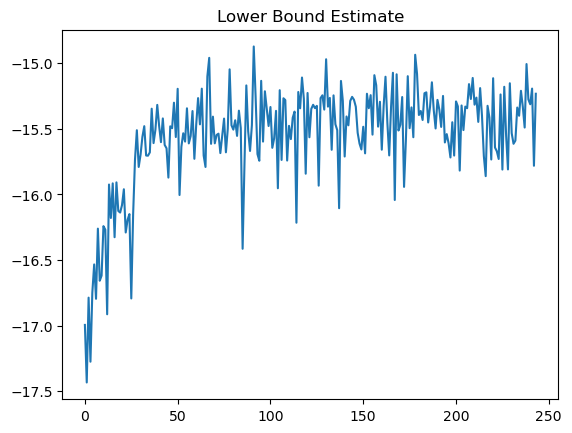

In [167]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

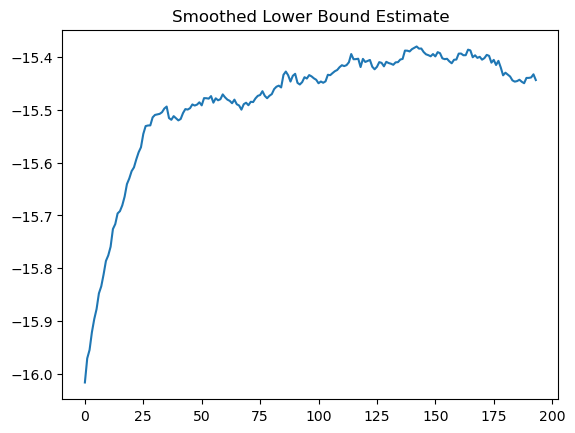

In [168]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [170]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = ss_multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (100 * np.exp(best_theta_tilde[:,1]) + 0) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = (0.9 * np.exp(best_theta_tilde[:,2]) + 0) / (np.exp(best_theta_tilde[:,2]) + 1)
best_theta = np.array([best_alpha, best_beta, best_gamma])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.72401287, 38.03298394,  0.62832319])

In [171]:
np.linalg.norm(posterior_mean_estimate - true_theta)

3.033211236159586

In [ ]:
# best_mu_untransformed = best_lambda_untransformed[0]
# best_vech_l_untransformed = list(best_lambda_untransformed[1])
# best_l_untransformed = np.zeros((num_coeffs, num_coeffs))
# for i in range(num_coeffs):
#     best_l_untransformed[i:num_coeffs,i] = best_vech_l_untransformed[:num_coeffs - i]
#     del best_vech_l_untransformed[:num_coeffs-i]
# best_Sigma_untransformed =  np.linalg.inv(best_l_untransformed @ best_l_untransformed.T)

# best_theta_tilde_untransformed = multivariate_normal.rvs(mean = best_mu_untransformed, cov = best_Sigma_untransformed, size = 1000)
# best_alpha_untransformed = (2 * np.exp(best_theta_tilde_untransformed[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde_untransformed[:,0]))
# best_beta_untransformed = (np.exp(best_theta_tilde_untransformed[:,1]) - 1) / (np.exp(best_theta_tilde_untransformed[:,1]) + 1)
# best_gamma_untransformed = np.exp(best_theta_tilde_untransformed[:,2])
# best_delta_untransformed = best_theta_tilde_untransformed[:,3]
# best_theta_untransformed = np.array([best_alpha_untransformed, best_beta_untransformed, best_gamma_untransformed, best_delta_untransformed])
# posterior_mean_estimate_untransformed = np.mean(best_theta_untransformed, axis = 1)
# posterior_mean_estimate_untransformed

In [ ]:
# best_mu_wass = best_lambda_wass[0]
# best_vech_l_wass = list(best_lambda_wass[1])
# best_l_wass = np.zeros((num_coeffs, num_coeffs))
# for i in range(num_coeffs):
#     best_l_wass[i:num_coeffs,i] = best_vech_l_wass[:num_coeffs - i]
#     del best_vech_l_wass[:num_coeffs-i]
# best_Sigma_wass =  np.linalg.inv(best_l_wass @ best_l_wass.T)

# best_theta_tilde_wass = multivariate_normal.rvs(mean = best_mu_wass, cov = best_Sigma_wass, size = 1000)
# best_alpha_wass = (2 * np.exp(best_theta_tilde_wass[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde_wass[:,0]))
# best_beta_wass = (np.exp(best_theta_tilde_wass[:,1]) - 1) / (np.exp(best_theta_tilde_wass[:,1]) + 1)
# best_gamma_wass = np.exp(best_theta_tilde_wass[:,2])
# best_delta_wass = best_theta_tilde_wass[:,3]
# best_theta_wass = np.array([best_alpha_wass, best_beta_wass, best_gamma_wass, best_delta_wass])
# posterior_mean_estimate_wass = np.mean(best_theta_wass, axis = 1)
# posterior_mean_estimate_wass

Text(0.5, 1.0, 'Posterior density of alpha')

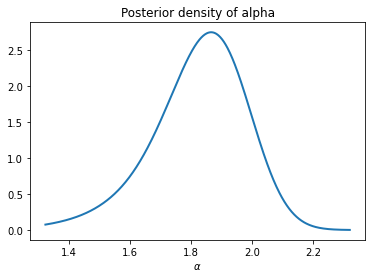

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(best_alpha.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

In [ ]:
# plt.figure()
# #x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
# x_plot = np.arange(min(np.mean(best_alpha_untransformed)-4*np.std(best_alpha_untransformed),np.mean(best_alpha)-4*np.std(best_alpha)), max(np.mean(best_alpha_untransformed)+4*np.std(best_alpha_untransformed), np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)

# kde_vb = KernelDensity(bandwidth=0.0055, kernel='gaussian')
# kde_vb.fit(best_alpha.reshape(-1, 1))
# y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

# #x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
# kde_vb_untransformed = KernelDensity(bandwidth=0.01, kernel='gaussian')
# kde_vb_untransformed.fit(best_alpha_untransformed.reshape(-1, 1))
# y_plot_vb_untransformed = kde_vb_untransformed.score_samples(x_plot.reshape(-1, 1))

# kde_vb_wass = KernelDensity(bandwidth=0.01, kernel='gaussian')
# kde_vb_wass.fit(best_alpha_wass.reshape(-1, 1))
# y_plot_vb_wass = kde_vb_wass.score_samples(x_plot.reshape(-1, 1))

# plt.plot(x_plot, np.exp(y_plot_vb_untransformed), '-', linewidth=2.0, label = 'VB - BSL')
# plt.plot(x_plot, np.exp(y_plot_vb_wass), '-', linewidth=2.0, label = 'WG - VB - BSL')
# plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')
# # only one line may be specified; full height
# plt.axvline(x = 1.5, ymin = 0, ymax = max(y_plot_vb_untransformed), color = 'black', label = 'True alpha')

# plt.legend()
# plt.xlabel(r'$\alpha$')
# plt.title('Posterior density of alpha')


Text(0.5, 1.0, 'Posterior density of beta')

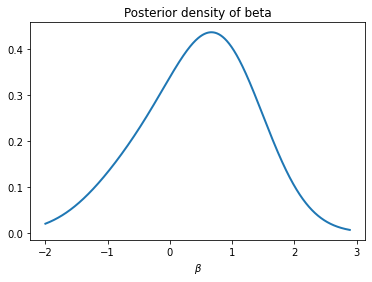

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.002)
kde = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde.fit(best_beta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

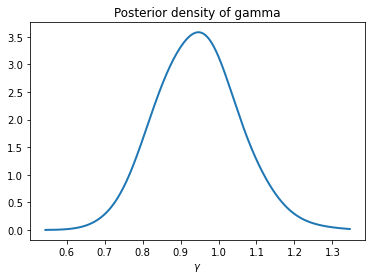

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_gamma.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

## VBSL-WG

In [ ]:
def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

In [ ]:
def summary_statistics(theta, n_samples, n_datasets, mixture_obj_seq):
    datasets = toad(theta[0], theta[1], theta[2],batch_size=n_datasets)
    n_summary_statistics = np.array([compute_summaries_stacked(datasets[:,:,i], lags)[0] for i in range(n_datasets)])
    # Wasserstein transform
    transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, n_summary_statistics)

    sample_mean = np.mean(transformed_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(transformed_summary_statistics).T)
    return sample_mean, sample_variance

def unbiased_log_likelihood(theta, actual_summary_statistics):
    ss = summary_statistics(theta, n_samples, num_datasets, mixture_obj_seq)
    sample_mean = ss[0]
    sample_variance = ss[1]
    diff_mean_s = actual_summary_statistics - sample_mean
    part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
    # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
    u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - part1
    return u_est_log_likelihood

In [ ]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 3 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        diag_inv_l = np.zeros((num_coeffs, num_coeffs))
        np.fill_diagonal(diag_inv_l, np.diag(np.linalg.inv(l)))
        gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        # mu_0 = np.array([np.log((true_theta[0] - 1)/(2 - true_theta[0])),np.log((true_theta[1] - 0)/(100 - true_theta[1])),np.log((true_theta[2] - 0)/(0.9 - true_theta[2]))])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.array([[ 3.94992238, -2.12969451,  0.47239626],
        #                 [-2.12969451, 21.85908684, -1.45228054],
        #                 [ 0.47239626, -1.45228054, 15.84326737]])
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in tqdm(range(self.samples)):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (100 * np.exp(theta_tilde_0[1]) + 0) / (1 + np.exp(theta_tilde_0[1]))
                    gamma_0 = (0.9 * np.exp(theta_tilde_0[2]) + 0) / (1 + np.exp(theta_tilde_0[2]))
                    theta_0 = np.array([alpha_0, beta_0, gamma_0])
                    
                    # Find gradient of LB
                    h_lambda_init = prior(theta_tilde_0) + unbiased_log_likelihood(theta_0, self.actual_summary_statistics) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (100 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    gamma_q = (0.9 * np.exp(theta_tilde_q[2]) + 0) / (1 + np.exp(theta_tilde_q[2]))
                    theta_q = np.array([alpha_q, beta_q, gamma_q])
                    
                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + unbiased_log_likelihood(theta_q, self.actual_summary_statistics) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [ ]:
nn_vb = GVB(200, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 50, 50)
nn_LB_estimate, nn_smoothed_LB_estimate, nn_best_lambda = nn_vb.vb_posterior(stop)

NameError: name 'transformed_summary_statistics' is not defined

In [ ]:
nn_best_lambda

array([array([ 0.7346095 , -0.70012037,  0.67198676]),
       array([ 4.36810339, -2.42016574,  0.40744222, 22.2448585 , -1.47434547,
              16.14305194])                                                   ],
      dtype=object)

<AxesSubplot: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

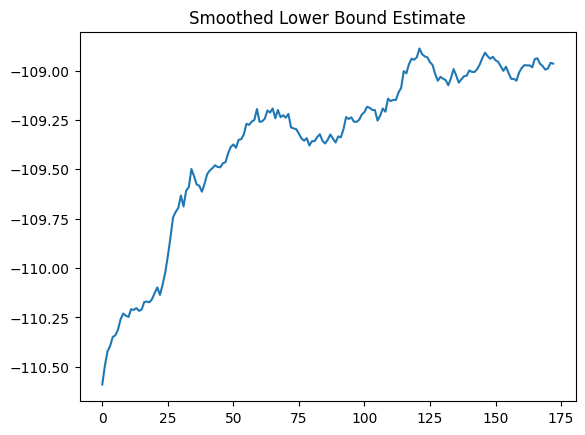

In [ ]:
lb_df = pd.DataFrame(np.array(nn_smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
best_mu = nn_best_lambda[0]
best_vech_l = list(nn_best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (100 * np.exp(best_theta_tilde[:,1]) + 0) / (1 + np.exp(best_theta_tilde[:,1]))
best_gamma = (0.9 * np.exp(best_theta_tilde[:,2]) + 0) / (1 + np.exp(best_theta_tilde[:,2]))
best_theta = np.array([best_alpha, best_beta, best_gamma])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.67309654, 33.20753569,  0.59541459])

In [ ]:
# num_samples = 50000
# num_burnin = 0.2 * num_samples

In [ ]:
# def sampler(samples):

# 	# ------------------- initialize MCMC

# 	w_size = num_coeffs  # num of weights and bias

# 	pos_w = np.ones((samples, w_size))  # posterior of all weights and bias over all samples
# 	pos_w_tilde = np.ones((samples, w_size))

# 	w_tilde = np.array([np.log((1.5-1.1)/(2-1.5)),np.log((0.5+1)/(1-0.5)),np.log(1),0])
# 	# w_tilde = [np.log((actual_summary_statistics[0]-1.1)/(2-actual_summary_statistics[0])), np.log((1+actual_summary_statistics[1])/(1-actual_summary_statistics[1])), np.log(actual_summary_statistics[2]), actual_summary_statistics[3]]

# 	alpha = (2 * np.exp(w_tilde[0]) + 1.1) / (1 + np.exp(w_tilde[0]))
# 	beta = (np.exp(w_tilde[1]) - 1) / (np.exp(w_tilde[1]) + 1)
# 	gamma = np.exp(w_tilde[2])
# 	delta = w_tilde[3]
# 	w = np.array([alpha, beta, gamma, delta])

# 	# GENERATE GAMMA
# 	Gamma_init = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
# 	adjusted_w = np.concatenate((np.tile(w, (gamma_samples, 1)), Gamma_init), axis = 1)
# 	# --------------------- 

# 	prior_current = prior(w_tilde)  # takes care of the gradients

# 	likelihood_current = variance_adjustment_unbiased_log_likelihood(adjusted_w)

# 	naccept = 0
		
# 	for i in range(samples - 1):
# 		if i < 2000:
# 			w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = ((0.1**2/w_size) * np.identity(w_size)))
# 		else:
# 			if i % 500 == 0:
# 				Sign = np.cov(pos_w_tilde[0:i, :].T)
# 			u_proposal = random.uniform(0, 1)
# 			if u_proposal < 0.05:
# 				w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = ((0.1**2/w_size) * np.identity(w_size)))
# 			else:
# 				w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = (2.38**2/w_size) * Sign)

# 		alpha_prop = (2 * np.exp(w_proposal_tilde[0]) + 1.1) / (1 + np.exp(w_proposal_tilde[0]))
# 		beta_prop = (np.exp(w_proposal_tilde[1]) - 1) / (np.exp(w_proposal_tilde[1]) + 1)
# 		gamma_prop = np.exp(w_proposal_tilde[2])
# 		delta_prop = w_proposal_tilde[3]
# 		w_proposal = np.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

# 		# GENERATE GAMMA
# 		Gamma = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
# 		adjusted_w_proposal = np.concatenate((np.tile(w_proposal, (gamma_samples, 1)), Gamma), axis = 1)
# 		# --------------------- 

# 		prior_proposal = prior(w_proposal_tilde)  # takes care of the gradients
# 		likelihood_proposal = variance_adjustment_unbiased_log_likelihood(adjusted_w_proposal)

# 		diff_prior = prior_proposal - prior_current

# 		diff_likelihood = likelihood_proposal - likelihood_current

# 		try:
# 			mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

# 		except OverflowError as e:
# 			mh_prob = 1


# 		u = random.uniform(0, 1)

# 		if u < mh_prob:
# 			# Update position 
# 			naccept += 1
# 			likelihood_current = likelihood_proposal
# 			prior_current = prior_proposal
# 			w_tilde = w_proposal_tilde
# 			w = w_proposal
# 			pos_w_tilde[i + 1,] = w_proposal_tilde	
# 			pos_w[i + 1,] = w_proposal
# 			print(i, pos_w[i + 1,])

# 		else:
# 			pos_w_tilde[i + 1,] = pos_w_tilde[i,]
# 			pos_w[i + 1,] = pos_w[i,]

# 	print(naccept, ' num accepted')
# 	print(naccept / (samples * 1.0) * 100, '% was accepted')
# 	accept_ratio = naccept / (samples * 1.0) * 100

# 	return (pos_w, pos_w_tilde, accept_ratio)

In [ ]:
# pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)

In [ ]:
# pos_w = np.loadtxt('mcmc_w_varobust.txt')
# pos_w_tilde = np.loadtxt('mcmc_w_tilde_varobust.txt')

In [ ]:
# plt.figure()
# pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
# pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
# x_plot = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.001)
# kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
# kde.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
# y_plot = kde.score_samples(x_plot.reshape(-1, 1))
# plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
# plt.xlabel(r'$\alpha$')
# plt.title('Posterior density of alpha')

In [ ]:
# plt.figure()
# pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
# pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
# #x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
# x_plot = np.arange(min(pos_alpha_mean-4*pos_alpha_std,np.mean(best_alpha)-4*np.std(best_alpha)), max(pos_alpha_mean+4*pos_alpha_std, np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
# kde_mcmc = KernelDensity(bandwidth=0.075, kernel='gaussian')
# kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
# y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

# #x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
# kde_vb = KernelDensity(bandwidth=0.155, kernel='gaussian')
# kde_vb.fit(best_alpha.reshape(-1, 1))
# y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

# plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
# plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

# plt.legend()
# plt.xlabel(r'$\alpha$')
# plt.title('Posterior density of alpha')


In [ ]:
# plt.figure()

# pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
# pos_beta_std = np.std(pos_w[int(num_burnin):,1])
# x_plot = np.arange((pos_beta_mean-4*pos_beta_std), (pos_beta_mean+4*pos_beta_std), 0.001)
# kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
# kde.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
# y_plot = kde.score_samples(x_plot.reshape(-1, 1))
# plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
# plt.xlabel(r'$\beta$')
# plt.title('Posterior density of beta')

In [ ]:
# plt.figure()
# pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
# pos_beta_std = np.std(pos_w[int(num_burnin):,1])
# #x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
# x_plot = np.arange(min(pos_beta_mean-4*pos_beta_std,np.mean(best_beta)-4*np.std(best_beta)), max(pos_beta_mean+4*pos_beta_std, np.mean(best_beta)+4*np.std(best_beta)), 0.001)
# kde_mcmc = KernelDensity(bandwidth=0.1, kernel='gaussian')
# kde_mcmc.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
# y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

# #x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
# kde_vb = KernelDensity(bandwidth=0.35, kernel='gaussian')
# kde_vb.fit(best_beta.reshape(-1, 1))
# y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

# plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
# plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

# plt.legend()
# plt.xlabel(r'$\beta$')
# plt.title('Posterior density of beta')


In [ ]:
# plt.figure()

# pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
# pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
# x_plot = np.arange((pos_gamma_mean-4*pos_gamma_std), (pos_gamma_mean+4*pos_gamma_std), 0.002)
# kde = KernelDensity(bandwidth=0.02, kernel='gaussian')
# kde.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
# y_plot = kde.score_samples(x_plot.reshape(-1, 1))
# plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
# plt.xlabel(r'$\gamma$')
# plt.title('Posterior density of gamma')

In [ ]:
# plt.figure()
# pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
# pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
# #x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
# x_plot = np.arange(min(pos_gamma_mean-4*pos_gamma_std,np.mean(best_gamma)-4*np.std(best_gamma)), max(pos_gamma_mean+4*pos_gamma_std, np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
# kde_mcmc = KernelDensity(bandwidth=0.0375, kernel='gaussian')
# kde_mcmc.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
# y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

# #x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
# kde_vb = KernelDensity(bandwidth=0.025, kernel='gaussian')
# kde_vb.fit(best_gamma.reshape(-1, 1))
# y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

# plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
# plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

# plt.legend()
# plt.xlabel(r'$\gamma$')
# plt.title('Posterior density of gamma')


In [ ]:
# alpha_trace = pos_w[int(num_burnin):,0]
# beta_trace = pos_w[int(num_burnin):,1]
# gamma_trace = pos_w[int(num_burnin):,2]
# delta_trace = pos_w[int(num_burnin):,3]

# x = np.arange(len(alpha_trace))
# plt.figure(facecolor = 'white')
# plt.plot(x, alpha_trace, label='Alpha')  
# plt.plot(x, beta_trace, label='Beta')  
# plt.plot(x, gamma_trace, label='Gamma')  
# plt.xlabel('Number of samples')
# plt.ylabel('Theta')
# plt.legend()
# plt.title("Trace Plot for Theta")
# plt.show()